<a href="https://colab.research.google.com/github/gammaSquared/deep-learning-power-market/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep learning in the Spannish power market**

This project is about applying deep learning to the following three tasks in the Spannish power market:

- Can we forecast 24 hours in advance better than the TSO?
- Can we predict electrical price by time of day better than TSO?
- Forecast intraday price or electrical demand hour-by-hour.

The dataset and suggested problems come from the Kaggle https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather 

## Setup
The needed information is contained in the repo https://github.com/gammaSquared/deep-learning-power-market The code and data is first cloned into the workspace of the notebook. Along with this notebook, there is an existing utils.py file containing functions and classes to keep things clean and tidy. 

## Deep learning 
Tensorflow and Keras will be used for deep learning. Moreover this is a timer series forecasting problem. An excellent resource on this is https://www.tensorflow.org/tutorials/structured_data/time_series

## Overall workflow
- Import, inspect and clean data 
- Analyze data and prepare features


In [2]:
# Clone repo
!git clone https://github.com/gammaSquared/deep-learning-power-market
# Change pwd to deep-learning power-market
%cd deep-learning-power-market

Cloning into 'deep-learning-power-market'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 40 (delta 12), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), done.
/content/deep-learning-power-market


## Import packages
- *utils* contains all the functions and classes in the repo

In [70]:
import utils as utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import data
- The csv files are contained in the folder *data* in the repo
- Change the current directory and list the files

In [4]:
# Change working directory to data and list files
%cd data
%ls

/content/deep-learning-power-market/data
energy_dataset.csv  weather_features.csv


## Inspect and clean data

After importing the data and inspecting it, there is missing data in the energy data while there is no missing data in the weather data. Let's drop the two columns which are all nans. Then convert time columns to datetime.

In [5]:
# Import data and inspect
df_energy = pd.read_csv('energy_dataset.csv')
df_weather = pd.read_csv('weather_features.csv')
print('Energy data')
print(f'Shape: \n {df_energy.shape}')
print(f'Nans: \n {df_energy.isna().sum()}')
display(df_energy.head())
print('Weather data')
print(f'Shape: \n {df_weather.shape}')
print(f'Nans: \n {df_weather.isna().sum()}')
display(df_weather.head())

# Drop nan columns
df_energy.drop(columns = ['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead'], inplace = True)
# Drop other nan rows
#df_energy.dropna(inplace = True)

# Convert time columns to datetime
df_energy['time'] = pd.to_datetime(df_energy['time'])
df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'])


Energy data
Shape: 
 (35064, 29)
Nans: 
 time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
gener

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


Weather data
Shape: 
 (178396, 17)
Nans: 
 dt_iso                 0
city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


## Investigate time points

Lets check if there are differences between the number of time stamps. By looking at the cardinality of each set we see that both contain the identical numeber of elements. By subtracting the weather set from the energy set we also see that the difference is zero.

In [6]:
# Create sets out of the time indexes 
energy_time_set = set(df_energy['time'])
weather_time_set = set(df_weather['dt_iso'])

# Compute the cardinality of the sets
print(f'Energy set cardinality:  {len(energy_time_set)}')
print(f'Weather set cardinality:  {len(weather_time_set)}')

# Elements in energy time set which are not in weather time set
print(f'Elements in energy time set which are not in weather time set: {len(energy_time_set - weather_time_set)}')


Energy set cardinality:  35064
Weather set cardinality:  35064
Elements in energy time set which are not in weather time set: 0


## Deal with nans
It turns out the nans look to appear ar random. Lets fill them through linear interpolation.

In [69]:
# See what the nans look like
df_energy[df_energy.isna().any(axis=1)]
# Fill through linear interpolation
df_energy.interpolate(method = 'linear', inplace = True)
# Very that there are no nans
print(f'Nans: \n {df_energy.isna().sum().sum()}')

Nans: 
 0


## Set time as index for both dataframes

In [ ]:
df_energy.set_index('time', drop = True, inplace = True)
df_weather.set_index('iso_time', drop = True, inplace = True)

# Inspect energy dataset

- To kick things off, lets inspect the energy dataset
- It turns out there is a mix of observational data as well as forecast
- There are some variables which are all zero. We don't need these and can drop them.

In [48]:
# Pop the forecast which we will compete against
try:
  df_tso_forecast = df_energy.pop('total load forecast')
except:
  None
# Drop all zero columns since they are not needed
all_zero_columns = [x for x in df_energy.columns if (df_energy[x] == 0).all()]
df_energy.drop(columns = all_zero_columns, inplace = True)              
# Show summary statistics 
display(df_energy.describe().transpose())               

,count,mean,std,min,25%,50%,75%,max
generation biomass,35064.0,383.531343,85.346266,0.00,333.0000,367.00,433.00,592.00
generation fossil brown coal/lignite,35064.0,448.094570,354.618269,0.00,0.0000,509.00,757.00,999.00
generation fossil gas,35064.0,5622.700647,2201.510984,0.00,4126.0000,4969.50,6429.00,20034.00
generation fossil hard coal,35064.0,4256.531271,1961.988937,0.00,2527.0000,4475.00,5839.00,8359.00
generation fossil oil,35064.0,298.342417,52.519927,0.00,263.0000,300.00,330.00,449.00
generation hydro pumped storage consumption,35064.0,475.582706,792.312704,0.00,0.0000,68.00,616.00,4523.00
generation hydro run-of-river and poundage,35064.0,972.201902,400.712304,0.00,637.0000,906.00,1250.00,2000.00
generation hydro water reservoir,35064.0,2605.534123,1835.175078,0.00,1078.0000,2165.00,3758.00,9728.00
generation nuclear,35064.0,6263.483430,840.272333,0.00,5759.0000,6564.00,7025.00,7117.00
generation other,35064.0,60.226030,20.238792,0.00,53.0000,57.00,80.00,106.00


# Analyze data

- Lets compute spearman's correlation between total load actual (which is the target variable) and other variables. It turns out it's close to zero for the wind variables. This seems reasonable - regardless of the consumptio the wind will be producing. Let's drop them.
- By computing the autocorrelation

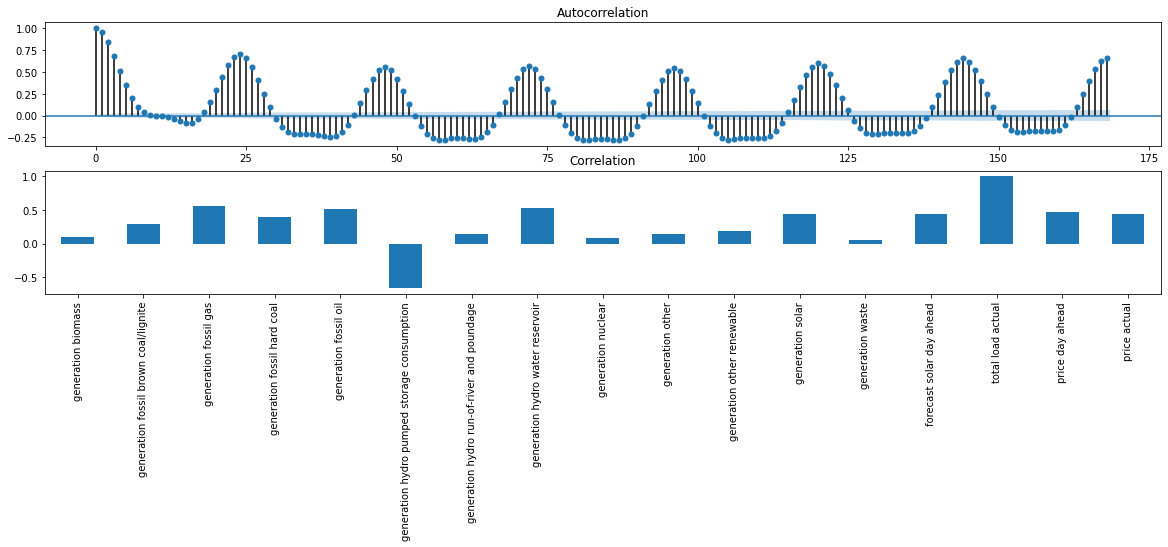

In [87]:
# Drop wind columns
# Shift all columns except target and forecast
# Copute spearmans's rho 
corr = df_energy.corr('spearman')
fig, ax = plt.subplots(2,1, figsize=(20,5))
corr['total load actual'].plot.bar(title ='Correlation', ax = ax[1])
sm.graphics.tsa.plot_acf(df_energy['total load actual'], lags=24*7, ax = ax[0])
#df_energy.drop(columns =['generation wind onshore', 'forecast wind onshore day ahead'], inplace = True)
plt.show()


## Other feature extraction
- Convert time to sine and cosine functions

In [143]:
# Number of seconds in a day
day = 24*60*60
# Number of seconds in an hour
hour = 60*60

timestamps = [dt.datetime.timestamp(x) for x in df_energy.index]
df_energy['Day sin'] = np.sin(np.array(timestamps) * (2 * np.pi / day))
df_energy['Day cos'] = np.cos(np.array(timestamps) * (2 * np.pi / day))

# Not needed to compute sine functions, mod60 = 0 
#df_energy['Hour sin'] = np.sin(np.array(timestamps) * (2 * np.pi / hour))
#df_energy['Hour cos'] = np.cos(np.array(timestamps) * (2 * np.pi / hour))


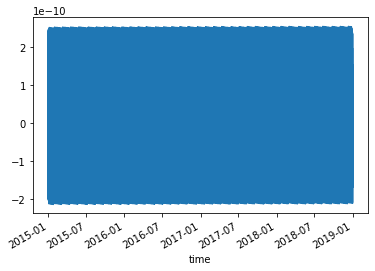

In [145]:
df_energy['Hour sin'].plot()

In [136]:
np.cos(np.array(timestamps)[0] *(2 * np.pi / minute))

1.0

In [142]:
timestamps[0] % 360

0.0